In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from matplotlib.ticker import MaxNLocator

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

# jet detection demo + comparison with S17

In [2]:
from dynlib.detect import jetaxis
from dynlib import dynfor
dynfor.config.jetint_thres = 1.e-11

In [3]:
from itertools import pairwise


def find_jets_spensberger(ds, no: int = 4000, nf: int = 100):
    ds = coarsen_da(ds, 1.5)
    dx, dy = compute_dx_dy(ds)
    lon_da = ds.lon.assign_coords(lon=("lon", np.arange(len(ds.lon))))
    lat_da = ds.lat.assign_coords(lat=("lat", np.arange(len(ds.lat))))
    u_smo = smooth(ds["u"], smooth_map={"lon+lat": ("fft", 0.2)})
    v_smo = smooth(ds["v"], smooth_map={"lon+lat": ("fft", 0.2)})
    all_points, all_group_ends = jetaxis(no, nf, u_smo.values, v_smo.values, dx, dy)
    jets = []
    for points, group_ends in zip(all_points, all_group_ends):
        end = np.argmax(group_ends[1:] == 0) + 1
        if end == 1:
            continue
        jets.append([])
        x, y, s = points.T
        x = lon_da.interp(lon=x, method="linear").values
        y = lat_da.interp(lat=y, method="linear").values
        group = np.asarray([x, y, s]).T
        for istart, iend in pairwise(group_ends[:end].astype(int)):
            jets[-1].append(pd.DataFrame(group[istart:iend], columns=["lon", "lat", "s"]))
    return all_jets_to_one_df(jets, ds.time.values)

In [4]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
exp = MultiVarExperiment(data_handlers)
ds = exp.ds.isel(time=slice(1200)).load()

In [5]:
all_jets_spensberger = find_jets_spensberger(ds)

 preparing
all jets to one df


100%|██████████| 1200/1200 [00:02<00:00, 501.56it/s]


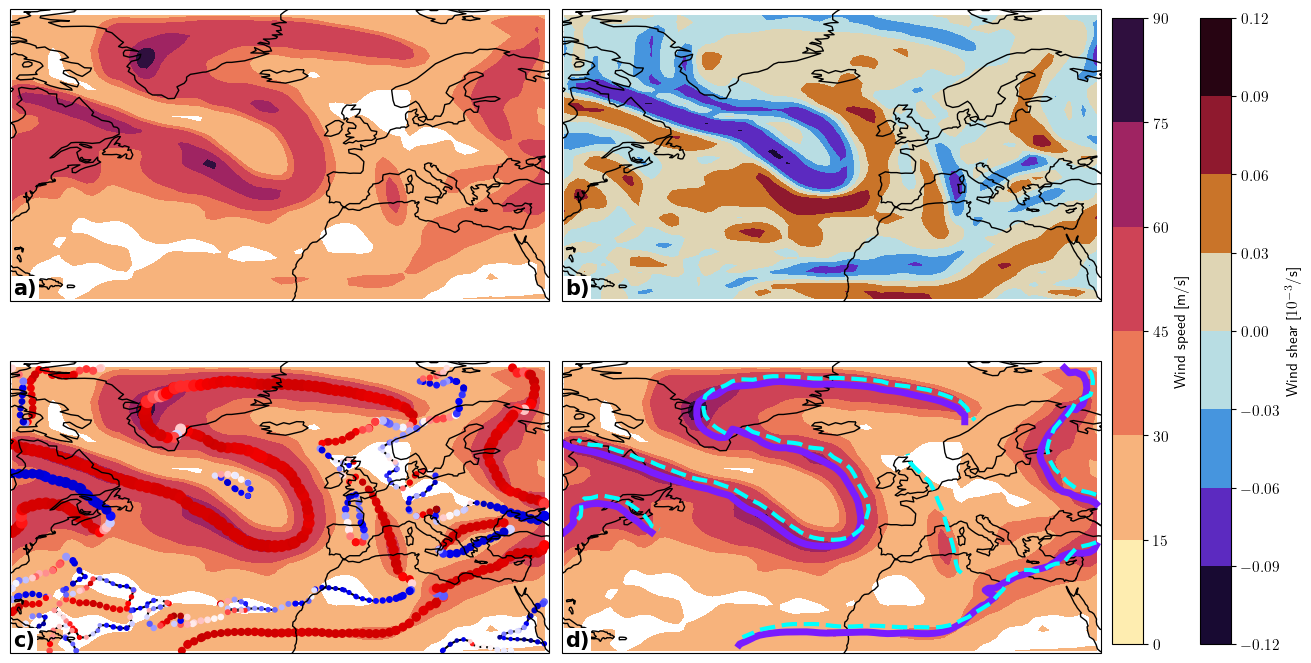

In [17]:
clu = Clusterplot(2, 2, get_region(ds))
# it = np.random.randint(0, ds.time.shape[0])
# ds_ = preprocess(ds.isel(time=it), smooth_s=0.2)
t = np.datetime64('1959-10-09T00:00:00.000000000')
ds_ = preprocess(ds.sel(time=t), smooth_s=0.2)
lon, lat = ds_.lon.values, ds_.lat.values
levels_wind = np.arange(0, 100, 15)
cmap1 = colormaps.matter
cmap1 = make_transparent(cmap1, len(levels_wind), 1, 1, 1)
norm1 = BoundaryNorm(levels_wind, cmap1.N)
im1 = ScalarMappable(norm1, cmap1)
cmap2 = colormaps.fusion_r
levels_sigma = MaxNLocator(7, symmetric=True).tick_values(-0.1, 0.1)
norm2 = BoundaryNorm(levels_sigma, cmap2.N, extend="neither")
im2 = ScalarMappable(norm2, cmap2)
clu.fig.colorbar(im2, ax=clu.axes, pad=0.01, shrink=0.9, spacing="proportional", label="Wind shear [$10^{-3}$/s]")
clu.fig.colorbar(im1, ax=clu.axes, pad=0.01, shrink=0.9, spacing="proportional", label="Wind speed [m/s]")

ax = clu.axes[0]
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, norm=norm1)

ax = clu.axes[1]
ax.contourf(lon, lat, ds_["sigma"] * 1000, cmap=cmap2, norm=norm2)

ax = clu.axes[2]
dx = (ds_.lon[1] - ds_.lon[0]).item()
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values * 1000, line_type="SeparateCode", quad_as_tri=False).lines(0.)
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, norm=norm1)
groups = []
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    x, y, s, alignment = group.to_dataframe()[["lon", "lat", "s", "alignment"]].to_numpy().T
    ax.plot(x, y, lw=1.5, color="black", zorder=-10)
    ax.scatter(x, y, c=alignment, s=s, cmap=colormaps.BlWhRe, vmin=-1.5, vmax=1.5)
    
ax = clu.axes[3]
wind_threshold: float = 23
jet_threshold: float = 1.e8
alignment_threshold: float = 0.4
mean_alignment_threshold: float = 0.7
contours, types = contour_generator(x=lon, y=lat, z=ds_["sigma"].values * 1000, line_type="SeparateCode", quad_as_tri=False).lines(0.)
ax.contourf(lon, lat, ds_["s"], cmap=cmap1, norm=norm1)
groups = []
for contour, types_ in zip(contours, types):
    if len(contour) < 15:
        continue
    cyclic: bool = 79 in types_ # code for line closing 
    group = interp_xy_ds(ds_, contour[::-1])
    group = compute_alignment(group)
    mask = (group["alignment"] > alignment_threshold) & (group["s"].values > wind_threshold)
    mask = mask.values
    indicess = get_runs_fill_holes(mask, hole_size=5, cyclic=cyclic)
    for indices in indicess:
        indices = np.unique(indices)
        if len(indices) < 5:
            continue
        group_df = group.to_dataframe().drop(columns="time").iloc[indices] # remove time
        group_ = group_df[["lon", "lat"]].values.astype(np.float32)
        labels = AgglomerativeClustering(n_clusters=None, distance_threshold=dx * 1.9, linkage="single").fit(group_).labels_
        masks = labels_to_mask(labels)
        for mask in masks.T:
            groups.append(group_df.iloc[mask])
jets = []
for group_df in groups:
    bigjump = np.diff(group_df["lon"]) < -3 * dx
    if any(bigjump):
        here = np.where(bigjump)[0][0] + 1
        group_df = group_df.apply(np.roll, args=(-here,), raw=True)
    if "P" in group_df and any(group_df["P"] < 0):
        continue
    group_ = group_df[["lon", "lat", "s"]].values.astype(np.float32)
    jet_int = jet_integral_haversine(group_)
    mean_alignment = np.mean(group_df["alignment"].values)
    if jet_int > jet_threshold and mean_alignment > mean_alignment_threshold:
        jets.append(group_df)
for jet in jets:
    x, y, s, P, alignment = jet[["lon", "lat", "s", "lev", "alignment"]].to_numpy().T
    # im = ax.scatter(x, y, c=P, cmap=cmap, norm=norm)
    ax.plot(x, y, color=COLORS[1], lw=5)
    
jets_spensberger = all_jets_spensberger.loc[t]
for jid, jet in jets_spensberger.groupby(level=0):
    i = int(jid[1:])
    ax.plot(*jet[["lon", "lat"]].to_numpy().T, color="cyan", linestyle="dashed", lw=3)
    
for ax, letter in zip(clu.axes, list("abcd")):
    ax.annotate(f"{letter})", (2.2, 5.1), xycoords='axes points', ha="left", va="baseline", fontweight="demi", fontsize=15, bbox={"boxstyle": "square, pad=0.1", "edgecolor": "none", "facecolor": "white"}, usetex=False)
    
plt.savefig(f"{FIGURES}/jet_detection_demo/full.png")

# width demo

In [55]:
all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
props_as_ds = exp.props_as_ds(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_ds_uncat)

In [56]:
MYBLUES = LinearSegmentedColormap.from_list("myblues", ["#ebebeb", COLORS_EXT[2]])
MYPURPLES = LinearSegmentedColormap.from_list("mypurples", ["#ebebeb", COLORS_EXT[5]])
MYPINKS = LinearSegmentedColormap.from_list("mypinks", ["#ebebeb", COLORS_EXT[8]])
MYREDS = LinearSegmentedColormap.from_list("myreds", ["#ebebeb", COLORS_EXT[11]])
PINKPURPLE = LinearSegmentedColormap.from_list("pinkpurple", [COLORS[2], COLORS[1]])

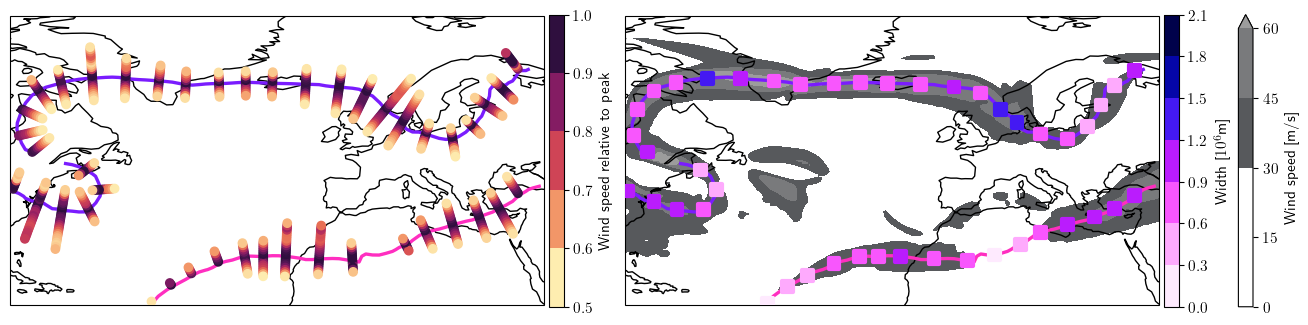

In [62]:
t = np.datetime64('1959-06-16T00:00:00.000000000')
are_polar = props_as_ds_uncat.is_polar.loc[t].values
da_ = ds["s"].loc[t]
clu = Clusterplot(1, 2, get_region(da_))
cmap = colormaps.greys_light
cmap.set_over("red")
clu.add_contourf([da_.copy(data=np.zeros(da_.shape)), da_], cmap=cmap, transparify=2, draw_cbar=True, cbar_kwargs={"pad": 0.01,  "shrink": 0.85, "label": "Wind speed [m/s]"})
axes = clu.axes
crit_func = lambda s_: max(s_ / 2, 25)
vmax_func = lambda s_: max(s_, 26)
cmap = colormaps.cet_l_bmw_r
norm = BoundaryNorm(np.arange(0, 2.11, .3), cmap.N)
im = ScalarMappable(norm, cmap)
plt.colorbar(im, ax=axes[1], shrink=0.85, pad=0.01, label="Width [$10^6$m]")
cmap2 = colormaps.matter
norm2 = BoundaryNorm(np.arange(0.5, 1.01, 0.1), cmap2.N)
im2 = ScalarMappable(norm2, cmap2)
plt.colorbar(im2, ax=axes[0], shrink=0.85, pad=0.01, label="Wind speed relative to peak")
marker = "o"
for (_, jet), is_polar in zip(all_jets_one_df.loc[t].groupby(level=0), are_polar):
    axes[0].plot(*jet[["lon", "lat"]].to_numpy().T, color=COLORS[2 - int(is_polar)], lw=2.4, ls="solid")
    axes[1].plot(*jet[["lon", "lat"]].to_numpy().T, color=COLORS[2 - int(is_polar)], lw=2.4, ls="solid")
    jet_ = jet.iloc[::5]
    lon, lat = da_.lon.values, da_.lat.values
    lo, la, s = jet_[["lon", "lat", "s"]].to_numpy().T
    dxds = np.gradient(lo)
    dyds = np.gradient(la)
    theta = np.arctan2(dyds, dxds)

    dn = 0.5
    t = np.arange(-10, 10 + dn, dn)
    half_length = len(t) // 2
    widths = np.zeros(len(jet_))
    for k in range(len(jet_)):
        normallons = np.cos(theta[k] + np.pi / 2) * t + lo[k]
        normallats = np.sin(theta[k] + np.pi / 2) * t + la[k]
        mask_valid = (normallons >= lon.min()) & (normallons <= lon.max()) & (normallats >= lat.min()) & (normallats <= lat.max())
        if all(mask_valid):
            slice_ = slice(half_length, 0, -1)
            normal_s = slice_1d(da_, {"lon": normallons[slice_], "lat": normallats[slice_]}).values
            normal_s = np.concatenate([normal_s, [0]])
            stop = np.argmax(normal_s <= crit_func(s[k]))
            try:
                endlo = normallons[slice_][stop]
                endla = normallats[slice_][stop]
            except IndexError:
                endlo = normallons[slice_][-1]
                endla = normallats[slice_][-1]
                stop = stop - 1
            axes[0].scatter(normallons[slice_][:stop], normallats[slice_][:stop], c=normal_s[:stop], cmap=cmap2, vmin=crit_func(s[k]), vmax=vmax_func(s[k]), marker=marker, zorder=100)
            halfw1 = haversine(lo[k], la[k], endlo, endla)
            
            slice_ = slice(half_length + 1, len(t))
            normal_s = slice_1d(da_, {"lon": normallons[slice_], "lat": normallats[slice_]}).values
            normal_s = np.concatenate([normal_s, [0]])
            stop = np.argmax(normal_s <= crit_func(s[k]))
            try:
                endlo = normallons[slice_][stop]
                endla = normallats[slice_][stop]
            except IndexError:
                endlo = normallons[slice_][-1]
                endla = normallats[slice_][-1]
                stop = stop - 1
            axes[0].scatter(normallons[slice_][:stop], normallats[slice_][:stop], c=normal_s[:stop], cmap=cmap2, vmin=crit_func(s[k]), vmax=vmax_func(s[k]), marker=marker, zorder=100)
            halfw2 = haversine(lo[k], la[k], endlo, endla)
            widths[k] = 2 * min(halfw1, halfw2)
        elif np.mean(mask_valid[:half_length]) > np.mean(mask_valid[half_length + 1:]):
            slice_ = slice(half_length, 0, -1)
            normal_s = slice_1d(da_, {"lon": normallons[slice_], "lat": normallats[slice_]}).values
            normal_s = np.concatenate([normal_s, [0]])
            stop = np.argmax(normal_s <= crit_func(s[k]))
            try:
                endlo = normallons[slice_][stop]
                endla = normallats[slice_][stop]
            except IndexError:
                endlo = normallons[slice_][-1]
                endla = normallats[slice_][-1]
                stop = stop - 1
            axes[0].scatter(normallons[slice_][:stop], normallats[slice_][:stop], c=normal_s[:stop], cmap=cmap2, vmin=crit_func(s[k]), vmax=vmax_func(s[k]), marker=marker, zorder=100)
            widths[k] = 2 * haversine(lo[k], la[k], endlo, endla)
        else:
            slice_ = slice(half_length + 1, -1)
            normal_s = slice_1d(da_, {"lon": normallons[slice_], "lat": normallats[slice_]}).values
            normal_s = np.concatenate([normal_s, [0]])
            stop = np.argmax(normal_s <= crit_func(s[k]))
            try:
                endlo = normallons[slice_][stop]
                endla = normallats[slice_][stop]
            except IndexError:
                endlo = normallons[slice_][-1]
                endla = normallats[slice_][-1]
            axes[0].scatter(normallons[slice_][:stop], normallats[slice_][:stop], c=normal_s[:stop], cmap=cmap2, vmin=crit_func(s[k]), vmax=vmax_func(s[k]), marker=marker, zorder=100)
            widths[k] = 2 * haversine(lo[k], la[k], endlo, endla)
    axes[1].scatter(*jet_[["lon", "lat"]].to_numpy().T, c=widths / 1e6, cmap=cmap, norm=norm, marker="s", lw=3, s=60, zorder=12)
    
plt.savefig(f"{FIGURES}/jet_detection_demo/width.png")

# Extreme climatology

In [2]:
sparse_exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", np.arange(1960, 2022, 5).tolist(), None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])

In [3]:
ds = sparse_exp.ds.load()
q_clim = compute_clim(ds["s"].quantile(np.arange(0.6, 1, 0.05), ["lon", "lat"]), "dayofyear")
q_clim = smooth(q_clim, {"dayofyear": ("win", 61)}).load()
q_clim.to_netcdf(f"{DATADIR}/ERA5/plev/results/s_q_clim.nc")

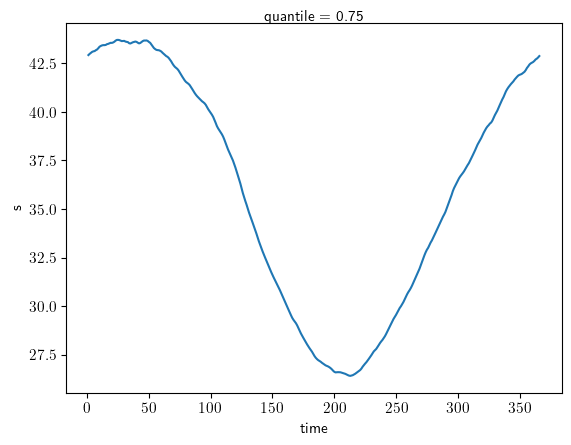

In [9]:
q_clim.isel(quantile=3).plot()

# Anim track demo

In [2]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])
all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
ds = exp.ds

flags = xr.DataArray(flags, coords={"time": ds.time.values, "jet": np.arange(flags.shape[1])})
slice_ = slice(pd.Timestamp("2020", unit="Y"), pd.Timestamp("2021", unit="Y"))
these_jets = all_jets_one_df.loc[slice_]
flags = flags.loc[slice_]
da = ds["s"].loc[slice_]

MovieWriter ffmpeg unavailable; using Pillow instead.


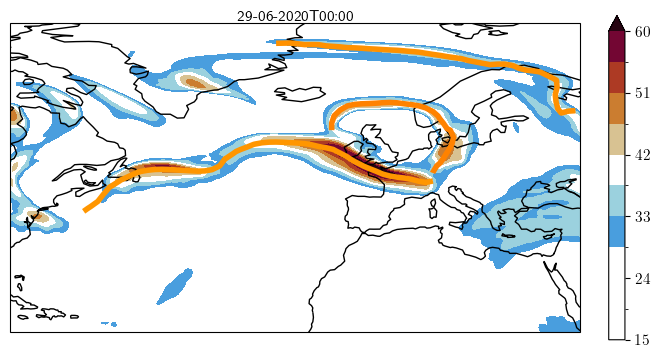

In [3]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, exp.region)
fig = clu.fig
ax = clu.axes[0]
times = da.time.values
lon, lat = da.lon.values, da.lat.values
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [da.isel(time=0)], transparify=3, q=0.9, nlevels=11,
)
cs = ax.contourf(
    lon, lat, da.isel(time=0).values, **kwargs_contourf
)
minflag = flags.min()
flags_ = flags.copy()
flags_ -= minflag
maxflag = int(np.nanmax(flags_.where(flags_ < flags.max())))
nturns = 30
flag_colors = colormaps.BlAqGrYeOrReVi200(np.linspace(0, nturns, maxflag) % 1)
segments = []
colors = []
for j, (_, jet) in enumerate(these_jets.loc[times[0]].groupby(level=0)):
    segments.append(jet[["lon", "lat"]].to_numpy())
    colors.append(flag_colors[flags_.loc[times[0], j]])
lc = LineCollection(segments, colors=colors, lw=4)
ax.add_collection(lc)
cbar = fig.colorbar(cs)

def animate(i):
    global lc
    global cs
    try:
        these_jets.loc[times[i]]
    except KeyError:
        return lc, cs
    cs.remove()
    segments = []
    colors = []
    for j, (_, jet) in enumerate(these_jets.loc[times[i]].groupby(level=0)):
        segments.append(jet[["lon", "lat"]].to_numpy())
        colors.append(flag_colors[flags_.loc[times[i], j]])
    lc.set_segments(segments)
    lc.set_colors(colors)
    cs = ax.contourf(
        lon, lat, da.isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(da.time[i].dt.strftime("%d-%m-%YT%H:00").item())
    return lc, cs


ani = FuncAnimation(fig, animate, frames=np.arange(6 * 4 * 30, 8 * 4 * 30 + 60, 4))
ani.save(f"{FIGURES}/jet_anim.gif", dpi=200, fps=1)